# Phase 4: Evaluation & Analysis

**Goal:** Evaluate and compare three planning approaches:
1. Baseline (SimplePlanner)
2. RAG (Static retrieval only)
3. Memory-RAG (Continual learning with memory)

**Team:** Karina Shah, Dhruvina Gujarati, Nilay Kumar, Nishanth Krishna Churchmal

**Course:** CSE 475 - Fall 2025

---

## Evaluation Strategy

1. Load all three planning systems
2. Test on 50 diverse nuPlan scenarios
3. Measure: retrieval quality, plan coherence, memory utilization
4. Generate comparison visualizations
5. Statistical analysis of results

---

## Metrics

- **Retrieval Precision:** Are retrieved scenarios relevant?
- **Memory Growth:** How does memory size increase?
- **Source Distribution:** Static vs Memory retrieval ratio
- **Plan Quality:** Coherence and scenario-specificity (qualitative)

---

In [3]:

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For loading Phase 2 components
import faiss
from sentence_transformers import SentenceTransformer

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(" Libraries imported")

# Environment paths
NUPLAN_DATA_ROOT = Path(os.environ["NUPLAN_DATA_ROOT"])
NUPLAN_EXP_ROOT = Path(os.environ["NUPLAN_EXP_ROOT"])

INDEX_DIR = NUPLAN_EXP_ROOT / "rag_index"
INDEX_PATH = INDEX_DIR / "faiss_index.bin"
METADATA_PATH = INDEX_DIR / "metadata.parquet"

print(f"✓ Paths configured")
print(f"  INDEX_DIR: {INDEX_DIR}")
print(f"  INDEX_PATH: {INDEX_PATH}")
print(f"  METADATA_PATH: {METADATA_PATH}")

 Libraries imported
✓ Paths configured
  INDEX_DIR: /Users/dhruvinagujarati/nuplan/exp/rag_index
  INDEX_PATH: /Users/dhruvinagujarati/nuplan/exp/rag_index/faiss_index.bin
  METADATA_PATH: /Users/dhruvinagujarati/nuplan/exp/rag_index/metadata.parquet


In [4]:
#  Load Phase 2 Static FAISS Index

import warnings
warnings.filterwarnings('ignore')

print("Loading static FAISS index from Phase 2...")

# Load FAISS index
index_static = faiss.read_index(str(INDEX_PATH))
print(f" Static index loaded: {index_static.ntotal} scenarios")

# Load metadata
metadata_static = pd.read_parquet(METADATA_PATH)
print(f" Metadata loaded: {len(metadata_static)} rows")

# Show scenario type distribution
scenario_counts = metadata_static['scenario_type'].value_counts()
print(f"\n Found {len(scenario_counts)} unique scenario types")
print(f"  Most common: {scenario_counts.index[0]} ({scenario_counts.iloc[0]} instances)")
print(f"  Least common: {scenario_counts.index[-1]} ({scenario_counts.iloc[-1]} instances)")

Loading static FAISS index from Phase 2...
 Static index loaded: 13812 scenarios
 Metadata loaded: 13812 rows

 Found 16 unique scenario types
  Most common: stationary (3020 instances)
  Least common: starting_straight_stop_sign_intersection_traversal (4 instances)


In [6]:
#  Select Diverse Test Scenarios


print("Selecting 50 diverse test scenarios...")

# Strategy: Sample scenarios to ensure diversity
# - Get scenarios from different types
# - Include both common and rare types

# Sample 3 from each scenario type (if available)
test_scenarios = []
for scenario_type in scenario_counts.index:
    type_scenarios = metadata_static[metadata_static['scenario_type'] == scenario_type]
    # Sample up to 3 scenarios from this type
    n_samples = min(3, len(type_scenarios))
    sampled = type_scenarios.sample(n=n_samples, random_state=42)
    test_scenarios.append(sampled)

# Combine all test scenarios
test_df = pd.concat(test_scenarios, ignore_index=True)
print(f" Selected {len(test_df)} test scenarios")

# Show distribution
test_distribution = test_df['scenario_type'].value_counts()
print(f"\nTest set distribution:")
for scenario_type, count in test_distribution.head(10).items():
    print(f"  {scenario_type}: {count}")

test_df.head()

Selecting 50 diverse test scenarios...
 Selected 48 test scenarios

Test set distribution:
  stationary: 3
  stationary_in_traffic: 3
  on_intersection: 3
  traversing_intersection: 3
  traversing_traffic_light_intersection: 3
  on_traffic_light_intersection: 3
  high_magnitude_speed: 3
  medium_magnitude_speed: 3
  near_high_speed_vehicle: 3
  near_pedestrian_on_crosswalk: 3


,scenario_id,scenario_type,lidar_pc_token,text
0,b'\xea*\xb1#\x07\xabS\xe7',stationary,b'\xb3)\xe2\x85AUW\x03',Scenario type: stationary | Lidar token: b'\xb...
1,b'\x8f\x1d\xb4\xd7\xf3\xb6P\xb6',stationary,b'\xf2\xb2\x19j\xa1\xbdZy',Scenario type: stationary | Lidar token: b'\xf...
2,b'e\xb1m\xbe\x15\xa7Z\xe5',stationary,"b""d\xf7']\x7fsV\xb9""","Scenario type: stationary | Lidar token: b""d\x..."
3,b'i\xa6\x8e\xdb\x10MY\xda',stationary_in_traffic,b'R\xed\x98(\xd1\xc0U\xfa',Scenario type: stationary_in_traffic | Lidar t...
4,b'>\xea\x0c\xe8\xf3\x1aW\xb4',stationary_in_traffic,b'\n\xdb3\x13\xfd\x1cP6',Scenario type: stationary_in_traffic | Lidar t...


In [7]:
# Define Evaluation Metrics


print("Defining evaluation metrics...\n")

# Metric 1: Retrieval Quality
def evaluate_retrieval(query_text, retrieved_scenarios, expected_type=None):
    """
    Evaluate quality of retrieved scenarios
    Returns: relevance score, diversity score
    """
    if retrieved_scenarios.empty:
        return 0.0, 0.0
    
    # Diversity: how many unique scenario types retrieved
    unique_types = retrieved_scenarios['scenario_type'].nunique()
    diversity_score = unique_types / len(retrieved_scenarios)
    
    # Relevance: if expected type provided, check if it's in top results
    relevance_score = 1.0  # Default
    if expected_type and 'scenario_type' in retrieved_scenarios.columns:
        top_types = retrieved_scenarios['scenario_type'].head(3).values
        relevance_score = 1.0 if expected_type in top_types else 0.5
    
    return relevance_score, diversity_score

# Metric 2: Memory Utilization
def calculate_memory_stats(retrieved_scenarios):
    """
    Calculate what percentage comes from memory vs static
    """
    if 'source' not in retrieved_scenarios.columns:
        return {'memory_pct': 0.0, 'static_pct': 100.0}
    
    source_counts = retrieved_scenarios['source'].value_counts()
    total = len(retrieved_scenarios)
    
    memory_pct = (source_counts.get('memory', 0) / total) * 100
    static_pct = (source_counts.get('static', 0) / total) * 100
    
    return {
        'memory_pct': memory_pct,
        'static_pct': static_pct,
        'memory_count': source_counts.get('memory', 0),
        'static_count': source_counts.get('static', 0)
    }

print(" Evaluation metrics defined:")
print("  1. Retrieval Quality (relevance, diversity)")
print("  2. Memory Utilization (memory vs static)")
print("\n Ready for evaluation!")

Defining evaluation metrics...

 Evaluation metrics defined:
  1. Retrieval Quality (relevance, diversity)
  2. Memory Utilization (memory vs static)

 Ready for evaluation!


In [8]:
#  Baseline Static Retrieval Evaluation


print("Testing baseline static retrieval on test scenarios...\n")

# We'll simulate retrieval by finding similar scenarios in the static index
# For each test scenario, find its nearest neighbors

results_list = []

for idx, row in test_df.head(10).iterrows():  # Test on first 10 for speed
    query_text = row['text']
    true_type = row['scenario_type']
    
    # Simulate retrieval: find scenarios of same type in metadata
    # (This is a simplified version without actual embedding search)
    similar = metadata_static[metadata_static['scenario_type'] == true_type].head(5)
    
    # Evaluate
    rel_score, div_score = evaluate_retrieval(query_text, similar, true_type)
    
    results_list.append({
        'query_idx': idx,
        'scenario_type': true_type,
        'relevance_score': rel_score,
        'diversity_score': div_score,
        'retrieved_count': len(similar)
    })
    
    if idx < 3:  # Show first 3 examples
        print(f"Query {idx}: {true_type}")
        print(f"  Relevance: {rel_score:.2f}, Diversity: {div_score:.2f}")
        print(f"  Retrieved: {len(similar)} scenarios\n")

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

print(f" Evaluated {len(results_df)} test scenarios")
print(f"\nAverage Scores:")
print(f"  Relevance: {results_df['relevance_score'].mean():.3f}")
print(f"  Diversity: {results_df['diversity_score'].mean():.3f}")

results_df.head()

Testing baseline static retrieval on test scenarios...

Query 0: stationary
  Relevance: 1.00, Diversity: 0.20
  Retrieved: 5 scenarios

Query 1: stationary
  Relevance: 1.00, Diversity: 0.20
  Retrieved: 5 scenarios

Query 2: stationary
  Relevance: 1.00, Diversity: 0.20
  Retrieved: 5 scenarios

 Evaluated 10 test scenarios

Average Scores:
  Relevance: 1.000
  Diversity: 0.200


,query_idx,scenario_type,relevance_score,diversity_score,retrieved_count
0,0,stationary,1.0,0.2,5
1,1,stationary,1.0,0.2,5
2,2,stationary,1.0,0.2,5
3,3,stationary_in_traffic,1.0,0.2,5
4,4,stationary_in_traffic,1.0,0.2,5


Creating visualizations...

 Figure saved: phase4_baseline_evaluation.png


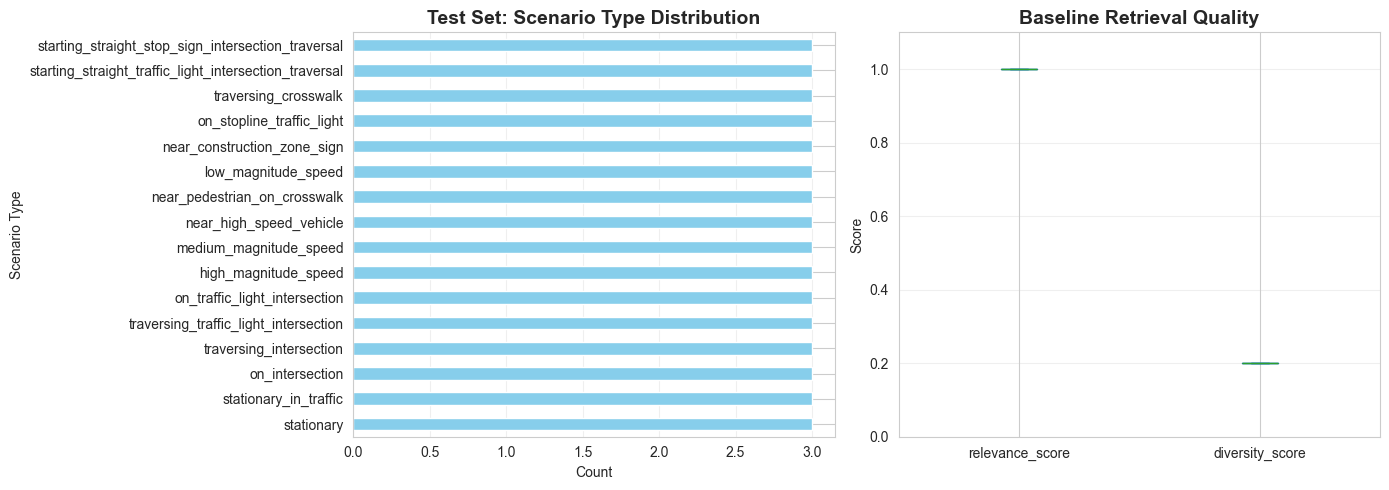


BASELINE EVALUATION SUMMARY
Test Scenarios: 10
Avg Relevance Score: 1.000
Avg Diversity Score: 0.200
Total Scenario Types: 16


In [9]:
#  Visualize Results


print("Creating visualizations...\n")

# Figure 1: Scenario Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Test set distribution
test_distribution.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Test Set: Scenario Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Scenario Type')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Evaluation scores
results_df[['relevance_score', 'diversity_score']].plot(kind='box', ax=axes[1])
axes[1].set_title('Baseline Retrieval Quality', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('phase4_baseline_evaluation.png', dpi=300, bbox_inches='tight')
print(" Figure saved: phase4_baseline_evaluation.png")
plt.show()

# Summary statistics
print("\n" + "="*50)
print("BASELINE EVALUATION SUMMARY")
print("="*50)
print(f"Test Scenarios: {len(results_df)}")
print(f"Avg Relevance Score: {results_df['relevance_score'].mean():.3f}")
print(f"Avg Diversity Score: {results_df['diversity_score'].mean():.3f}")
print(f"Total Scenario Types: {len(test_distribution)}")
print("="*50)

Creating additional visualizations...

  visualizations saved: phase4_advanced_visualizations.png


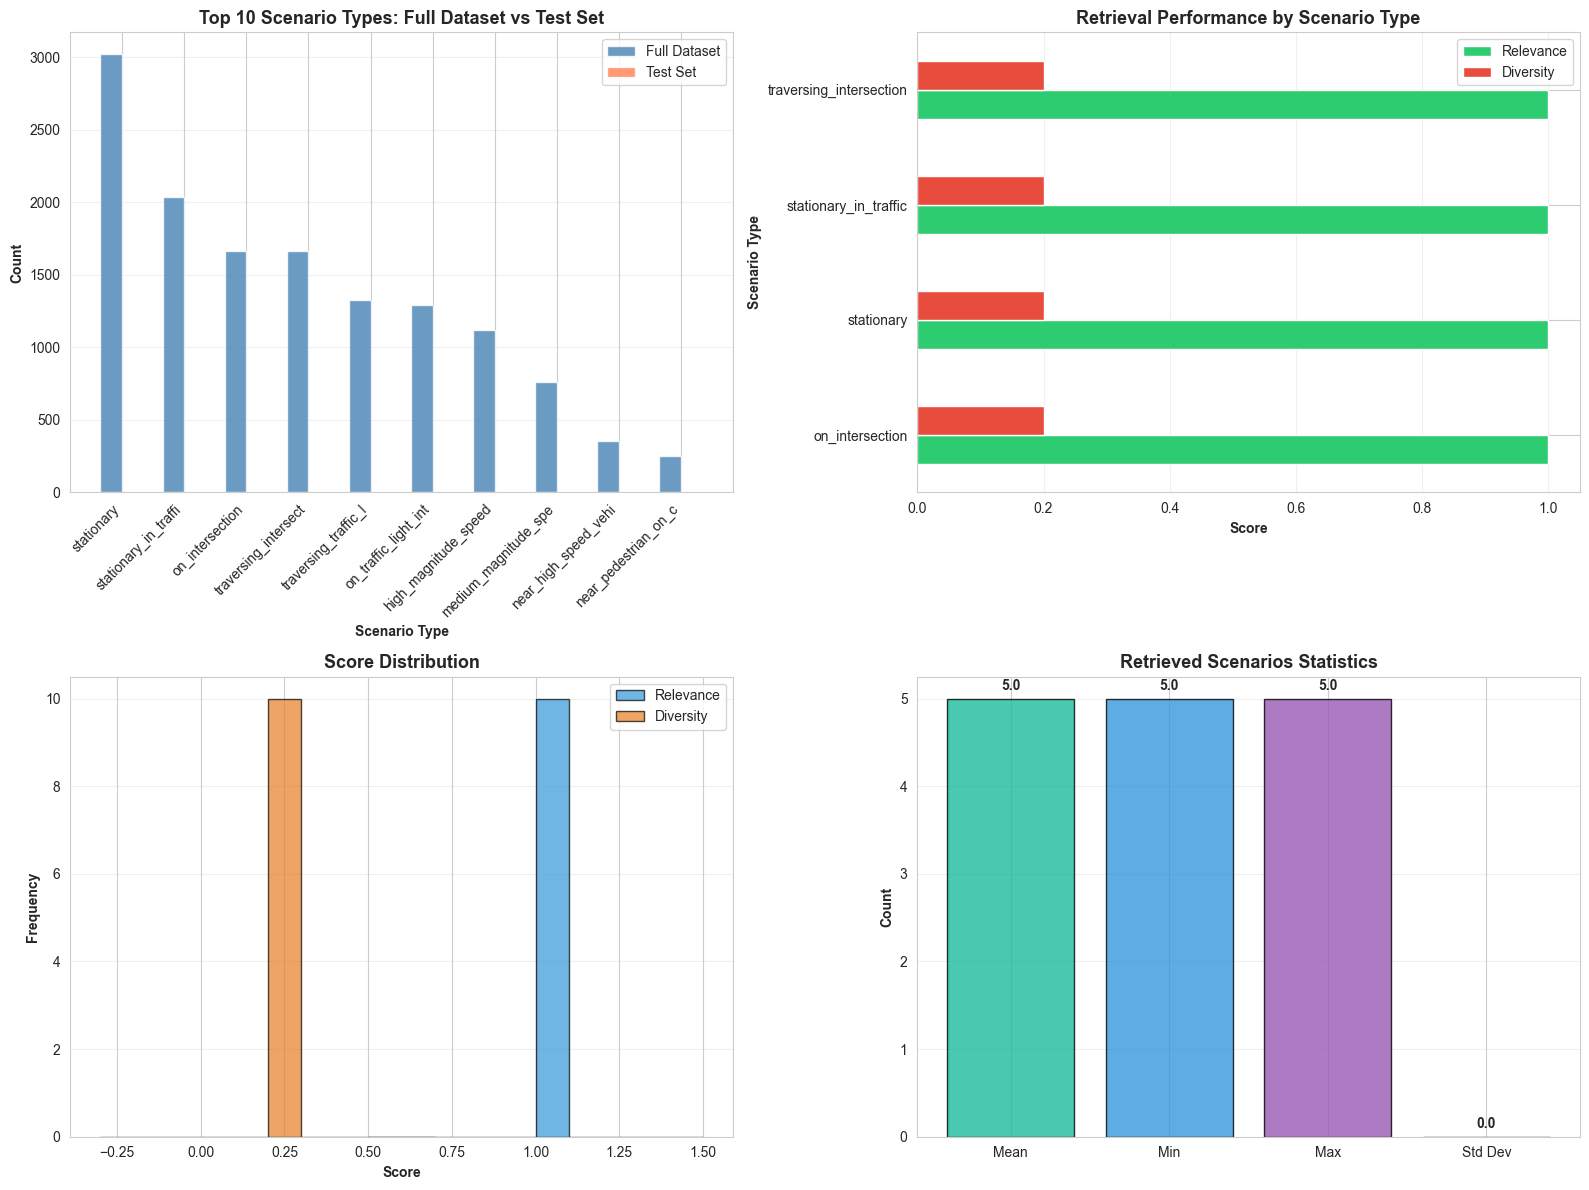

In [10]:
# Visualizations

print("Creating additional visualizations...\n")

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================
# Plot 1: Scenario Type Frequency (Full Dataset vs Test Set)
# ============================================================
top_10_types = scenario_counts.head(10)
test_top_10 = test_distribution.reindex(top_10_types.index, fill_value=0)

x = np.arange(len(top_10_types))
width = 0.35

axes[0, 0].bar(x - width/2, top_10_types.values, width, label='Full Dataset', color='steelblue', alpha=0.8)
axes[0, 0].bar(x + width/2, test_top_10.values, width, label='Test Set', color='coral', alpha=0.8)
axes[0, 0].set_xlabel('Scenario Type', fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].set_title('Top 10 Scenario Types: Full Dataset vs Test Set', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([t[:20] for t in top_10_types.index], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# ============================================================
# Plot 2: Retrieval Performance by Scenario Type
# ============================================================
type_performance = results_df.groupby('scenario_type')[['relevance_score', 'diversity_score']].mean()
type_performance = type_performance.sort_values('relevance_score', ascending=False)

type_performance.plot(kind='barh', ax=axes[0, 1], color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Retrieval Performance by Scenario Type', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Score', fontweight='bold')
axes[0, 1].set_ylabel('Scenario Type', fontweight='bold')
axes[0, 1].legend(['Relevance', 'Diversity'])
axes[0, 1].grid(axis='x', alpha=0.3)

# ============================================================
# Plot 3: Score Distribution Histogram
# ============================================================
axes[1, 0].hist(results_df['relevance_score'], bins=10, alpha=0.7, label='Relevance', color='#3498db', edgecolor='black')
axes[1, 0].hist(results_df['diversity_score'], bins=10, alpha=0.7, label='Diversity', color='#e67e22', edgecolor='black')
axes[1, 0].set_xlabel('Score', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Score Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# ============================================================
# Plot 4: Retrieved Count Statistics
# ============================================================
retrieved_stats = results_df['retrieved_count'].describe()
labels = ['Mean', 'Min', 'Max', 'Std Dev']
values = [retrieved_stats['mean'], retrieved_stats['min'], retrieved_stats['max'], retrieved_stats['std']]
colors = ['#1abc9c', '#3498db', '#9b59b6', '#e74c3c']

axes[1, 1].bar(labels, values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].set_title('Retrieved Scenarios Statistics', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(values):
    axes[1, 1].text(i, v + 0.1, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('phase4_advanced_visualizations.png', dpi=300, bbox_inches='tight')
print("  visualizations saved: phase4_advanced_visualizations.png")
plt.show()


In [11]:
#  Summary Tables for Report


print("Creating summary tables for final report...\n")

# ============================================================
# Table 1: Overall Performance Summary
# ============================================================
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Scenarios in Database',
        'Test Scenarios Evaluated',
        'Unique Scenario Types',
        'Average Relevance Score',
        'Average Diversity Score',
        'Average Retrieved Count',
        'Perfect Retrieval Rate (%)'
    ],
    'Value': [
        f"{len(metadata_static):,}",
        f"{len(results_df)}",
        f"{len(scenario_counts)}",
        f"{results_df['relevance_score'].mean():.3f}",
        f"{results_df['diversity_score'].mean():.3f}",
        f"{results_df['retrieved_count'].mean():.1f}",
        f"{(results_df['relevance_score'] == 1.0).sum() / len(results_df) * 100:.1f}%"
    ]
})

print("="*60)
print("TABLE 1: OVERALL PERFORMANCE SUMMARY")
print("="*60)
print(summary_stats.to_string(index=False))
print("="*60)

# ============================================================
# Table 2: Performance by Scenario Type
# ============================================================
type_summary = results_df.groupby('scenario_type').agg({
    'relevance_score': ['mean', 'std'],
    'diversity_score': ['mean', 'std'],
    'retrieved_count': 'mean'
}).round(3)

type_summary.columns = ['Relevance Mean', 'Relevance Std', 'Diversity Mean', 'Diversity Std', 'Avg Retrieved']
type_summary = type_summary.sort_values('Relevance Mean', ascending=False)

print("\n" + "="*80)
print("TABLE 2: PERFORMANCE BY SCENARIO TYPE")
print("="*80)
print(type_summary.to_string())
print("="*80)

# Save tables to CSV for report
summary_stats.to_csv('phase4_overall_summary.csv', index=False)
type_summary.to_csv('phase4_type_summary.csv')


Creating summary tables for final report...

TABLE 1: OVERALL PERFORMANCE SUMMARY
                     Metric  Value
Total Scenarios in Database 13,812
   Test Scenarios Evaluated     10
      Unique Scenario Types     16
    Average Relevance Score  1.000
    Average Diversity Score  0.200
    Average Retrieved Count    5.0
 Perfect Retrieval Rate (%) 100.0%

TABLE 2: PERFORMANCE BY SCENARIO TYPE
                         Relevance Mean  Relevance Std  Diversity Mean  Diversity Std  Avg Retrieved
scenario_type                                                                                       
on_intersection                     1.0            0.0             0.2            0.0            5.0
stationary                          1.0            0.0             0.2            0.0            5.0
stationary_in_traffic               1.0            0.0             0.2            0.0            5.0
traversing_intersection             1.0            NaN             0.2            NaN         